<a href="https://colab.research.google.com/github/KacperGrodecki/nieruchomosci-mazowieckie/blob/0.0.4/mazowieckie_colab_rysunki_i_analiza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn import svm
import pandas as pd
import numpy as np
np.random.seed(7)
from google.colab import drive
import seaborn as sns
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import pandas as pd
#from otoDomScraper import daneDomu
#from random import randrange
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import statistics
from sklearn.cluster import AffinityPropagation
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.decomposition import FastICA
from sklearn import preprocessing
from IPython.display import Javascript
import requests
from collections import OrderedDict
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def toNum2(txt):
    if type(txt) is int:
        return txt
    elif (type(txt) is str):
        digs = re.findall(r'\d+', txt)
        if len(digs) == 1:
            return int(digs[0])
        elif len(digs) == 2:
            return 1000 * int(digs[0]) + int(digs[1])
        elif len(digs) == 3:
            return 1000000 * int(digs[0]) + 1000 * int(digs[1]) + int(digs[0])

    #   return int(digs)


def toNum1(txt):
    if type(txt) is str:
        digs = re.findall(r'\d+', txt)
        if len(digs) == 1:
            return int(digs[0])
        elif len(digs) == 2 and (txt[1] != ' '):
            return int(digs[0]) + 0.01 * int(digs[1])
        elif len(digs) == 3:
            return 1000 * int(digs[0]) + int(digs[1]) + 0.001 * int(digs[2])
        elif (type(txt) is str) and (txt[1] == ' '):
            digs = re.findall(r'\d+', txt)
            return 1000 * int(digs[0]) + int(digs[1])
    else:
        return txt


def toNum3(txt):
    if type(txt) == int:
        return txt
    return int(re.findall(r'\d+', txt)[0])

def pietra(txt):
    if type(txt) is str:
        if '0' in txt:
            return 0
        if '1' in txt:
            return 1
        elif '2' in txt:
            return 2
        elif '3' in txt:
            return 3
        elif 'parterowy' in txt:
            return 0
    else:
        return txt

def cities(x):
    dist=x.split()[4]
    #city=x.split()[5]
    if dist=='warszawski':
        return x.split()[6]
    elif dist in ['Warszawa','Radom','Płock','Siedlce']:
        return dist
    else:
        try:
            return x.split()[5]
        except:
            return 'unknown'

def region(x):
    if x.split()[4]=='Warszawa':
        try:
            return x.split()[5]
        except:
            return ''
    else:
        return ''

In [4]:
def get_voivodeships():
    # problem - too many voivodeships, historical ones are mixed together
    # solution - just cut the list after 16-th item
    
    # request voivodeships of poland(wd:Q36),
    # cut after 16 voivodeships, the rest are historical ones
    # https://query.wikidata.org/#%20%20%20%20SELECT%20%3Fvoivodeship%20%3FvoivodeshipLabel%20%3Flatitude%20%3Flongitude%20%3Fadmininistrative_teritorial_entity%0A%20%20%20%20WHERE%20%7B%0A%20%20%20%20%20%20%3Fvoivodeship%20wdt%3AP31%20wd%3AQ150093%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wdt%3AP131%20%3Fadmininistrative_teritorial_entity%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20p%3AP625%2Fpsv%3AP625%20%5B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wikibase%3AgeoLatitude%20%3Flatitude%20%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wikibase%3AgeoLongitude%20%3Flongitude%20%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5D.%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20FILTER%28%3Fadmininistrative_teritorial_entity%20%3D%20wd%3AQ36%29.%0A%20%20%20%20%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22pl%22.%20%7D%0A%20%20%20%20%7D%0A%20%20%20%20ORDER%20BY%20DESC%28%3Fvoivodeship%29%0A%20%20%20%20LIMIT%2016%0A
    url = 'https://query.wikidata.org/sparql'
    query = '''
    SELECT ?voivodeship ?voivodeshipLabel ?latitude ?longitude ?admininistrative_teritorial_entity
    WHERE {
      ?voivodeship wdt:P31 wd:Q150093;
                   wdt:P131 ?admininistrative_teritorial_entity;
                   p:P625/psv:P625 [
                       wikibase:geoLatitude ?latitude ;
                       wikibase:geoLongitude ?longitude ;
                   ].               
      FILTER(?admininistrative_teritorial_entity = wd:Q36).
      SERVICE wikibase:label { bd:serviceParam wikibase:language "pl". }
    }
    ORDER BY DESC(?voivodeship)
    LIMIT 16
    '''
    r = requests.get(url, params = {'format': 'json', 'query': query})
    data = r.json()

    # convert json to dataframe
    voivodeships = []
    for item in data['results']['bindings']:
        voivodeships.append(OrderedDict(
        {
            'voivodeship':      item['voivodeshipLabel']['value'].lower(),
            'latitude':         float(item['latitude']['value']),        
            'longitude':        float(item['longitude']['value']),                    
            'wikidata_item_id': item['voivodeship']['value'].split('/')[-1]
        }))
    #     print(item,'\n')    
    return pd.DataFrame(voivodeships)


In [5]:
def get_warsaw_districts():
    # problem  - some districts have two sets of coordinates which differ slighlty
    # solution - drop the one with worse precision (larger value), this seems to be consistent with the wikipedia data
    # to do    - the above is not true for ['Wola'], change it
    
    # https://query.wikidata.org/#SELECT%20%3Fdistrict_of_Warsaw%20%3Fdistrict_of_WarsawLabel%20%3Flat%20%3Flon%20%3FgeoPrecision%20%0AWHERE%20%7B%0A%20%20%3Fdistrict_of_Warsaw%20%20wdt%3AP31%20wd%3AQ4286337%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wdt%3AP17%20wd%3AQ36%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wdt%3AP131%20wd%3AQ270%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20p%3AP625%2Fpsv%3AP625%20%5B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wikibase%3AgeoLatitude%20%3Flat%20%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wikibase%3AgeoLongitude%20%3Flon%20%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wikibase%3AgeoPrecision%20%20%3FgeoPrecision%3B%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5D%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22pl%22.%20%7D%0A%7D
    url = 'https://query.wikidata.org/sparql'
    query = '''
    SELECT ?warsaw_district ?warsaw_districtLabel ?latitude ?longitude ?geoPrecision 
    WHERE {
      ?warsaw_district  wdt:P31 wd:Q4286337;
                           wdt:P17 wd:Q36;
                           wdt:P131 wd:Q270;
                           p:P625/psv:P625 [
                               wikibase:geoLatitude ?latitude ;
                               wikibase:geoLongitude ?longitude ;
                               wikibase:geoPrecision  ?geoPrecision;                                       
                           ]
      SERVICE wikibase:label { bd:serviceParam wikibase:language "pl". }
    }
    ORDER BY ASC(?warsaw_districtLabel)
    '''
    r = requests.get(url, params = {'format': 'json', 'query': query})
#     print(r.json())
    data = r.json()

    # convert json to dataframe
    warsaw_districts = []
    for item in data['results']['bindings']:
#         print(item,'\n')    
        warsaw_districts.append(OrderedDict(
        {
            'warsaw_district':  item['warsaw_districtLabel']['value'].lower(),
            'latitude':         float(item['latitude']['value']),        
            'longitude':        float(item['longitude']['value']),                    
            'geoPrecision':     float(item['geoPrecision']['value']),                                
            'wikidata_item_id': item['warsaw_district']['value'].split('/')[-1]
        }))
    
    warsaw_districts = pd.DataFrame(warsaw_districts).sort_values(by=['warsaw_district'])
    
    # if duplicate warsaw districts exist, take the one with better precision (lower value), do the opposite in case of 'Wola' 
    for district in warsaw_districts['warsaw_district']:
        if np.sum(warsaw_districts['warsaw_district'] == district) > 1: # duplicate district found
            if district != 'wola':            
                district_to_drop_idx = warsaw_districts.loc[warsaw_districts['warsaw_district'] == district, 'geoPrecision'].idxmax()
            elif district == 'wola':
                district_to_drop_idx = warsaw_districts.loc[warsaw_districts['warsaw_district'] == district, 'geoPrecision'].idxmin()
#             print(district+':\t', district_to_drop_idx, '\n')
            warsaw_districts = warsaw_districts.drop(district_to_drop_idx).reset_index(drop=True)  
            
    return warsaw_districts

In [6]:
def get_cities():
    # Description:
    #  - sparql query is constructed for different types of cities: city with powiat rights ('Q925381'), urban municipality of Poland (Q2616791), and the second for "regular" city ('Q515')
    # Problems:
    #   1) some cities have more than one set of coordinates
    #   2) filter within masovian voivodeship
    # Solutions:
    #   1) retain only the one with best precision (lowest value)
    #   2) we can use .contains method from geopandas package, check the crs of Point from wikidata (https://www.kaggle.com/alexisbcook/proximity-analysis)
    # To do:
    #   1) check this approach
      
    # Get both types of cities: cities with powiat rights (Q925381), urban municipality of Poland (Q2616791), and the the "regular" cities (Q515)
    # https://docs.python.org/3/reference/lexical_analysis.html#f-strings
    # https://query.wikidata.org/#SELECT%20%3Fcity%20%3FcityLabel%20%3Flatitude%20%3Flongitude%20%3FgeoPrecision%20%3Fcoord%0AWHERE%20%7B%0A%20%20%3Fcity%20%20wdt%3AP31%20wd%3AQ925381%3B%0A%20%20%20%20%20%20%20%20%20wdt%3AP17%20wd%3AQ36%3B%0A%20%20%20%20%20%20%20%20%20%23wdt%3AP131%20wd%3AQ54169%3B%0A%20%20%20%20%20%20%20%20%20p%3AP625%20%5B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20psv%3AP625%20%5B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wikibase%3AgeoLatitude%20%3Flatitude%20%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wikibase%3AgeoLongitude%20%3Flongitude%20%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wikibase%3AgeoPrecision%20%20%3FgeoPrecision%3B%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5D%3B%0A%20%20%20%20%20%20%20%20%20ps%3AP625%20%3Fcoord%20%0A%20%20%20%20%20%20%20%20%20%5D%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22pl%22.%20%7D%0A%7D
    # https://query.wikidata.org/#SELECT%20%3Fcity%20%3FcityLabel%20%3Flatitude%20%3Flongitude%20%3FgeoPrecision%20%3Fcoord%0AWHERE%20%7B%0A%20%20%3Fcity%20%20wdt%3AP31%20wd%3AQ515%3B%0A%20%20%20%20%20%20%20%20%20wdt%3AP17%20wd%3AQ36%3B%0A%20%20%20%20%20%20%20%20%20%23wdt%3AP131%20wd%3AQ54169%3B%0A%20%20%20%20%20%20%20%20%20p%3AP625%20%5B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20psv%3AP625%20%5B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wikibase%3AgeoLatitude%20%3Flatitude%20%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wikibase%3AgeoLongitude%20%3Flongitude%20%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wikibase%3AgeoPrecision%20%20%3FgeoPrecision%3B%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5D%3B%0A%20%20%20%20%20%20%20%20%20ps%3AP625%20%3Fcoord%20%0A%20%20%20%20%20%20%20%20%20%5D%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22pl%22.%20%7D%0A%7D
    cities_all = pd.DataFrame()
    url = 'https://query.wikidata.org/sparql'
    data = pd.DataFrame()
    types_of_city = {'city with powiat rights': 'Q925381', 'urban municipality of Poland ': 'Q2616791', 'city': 'Q515'}
    for type_of_city, type_of_city_sparql in types_of_city.items():
#         print('\n\nCities of type \'' + type_of_city + '\' (' + str(type_of_city_sparql) + '):')
        query = f''' 
            SELECT ?city ?cityLabel ?latitude ?longitude ?geoPrecision ?coord
            WHERE {{
              ?city  wdt:P31 wd:{type_of_city_sparql};
                     wdt:P17 wd:Q36;
                     #wdt:P131 wd:Q54169;
                     p:P625 [
                             psv:P625 [
                                       wikibase:geoLatitude ?latitude ;
                                       wikibase:geoLongitude ?longitude ;
                                       wikibase:geoPrecision  ?geoPrecision;      
                                      ];
                     ps:P625 ?coord 
                     ]
              SERVICE wikibase:label {{ bd:serviceParam wikibase:language "pl". }}
            }}
            '''
        r = requests.get(url, params = {'format': 'json', 'query': query})
        data = r.json()

        
        # Convert json to dataframe
        cities = []
        for item in data['results']['bindings']:
#             print(item,'\n')    
            cities.append(OrderedDict(
            {
                'city':             item['cityLabel']['value'].lower(),
                'latitude':         float(item['latitude']['value']),        
                'longitude':        float(item['longitude']['value']),                    
                'geoPrecision':     float(item['geoPrecision']['value']),                                
                'wikidata_item_id': item['city']['value'].split('/')[-1]
            }))
        cities = pd.DataFrame(cities).sort_values(by=['city']).reset_index(drop=True)
#         print('Number of cities of type', type_of_city+':', len(cities))

        
        # Find those city names that have multiple instaces:
        #   - those with the same wikidata_item_id are the same city with multiple coordinate sets - retain only the set with best (lowest) geoPrecision,
        #   - those with different wikidata_item_id are different cities and should not be considered with the following procedure.
        # https://stackoverflow.com/questions/55360314/pandas-groupby-take-counts-greater-than-1
        cities_with_the_same_name_and_wikidataItemId = cities.loc[cities.groupby(['city', 'wikidata_item_id'])['geoPrecision'].transform('count') > 1].reset_index(drop=True) # cities.loc[cities.duplicated(subset=['city', 'wikidata_item_id'], keep=False)].reset_index(drop=True)
#         print('Cities with the same name and the same wikidata_item_id:', len(cities_with_the_same_name_and_wikidataItemId))
        
    
        # If multiple instances of any city exist, retain only the one with the best precision (lowest value) 
#         print('Cities with multiple instances:', len(cities_with_the_same_name_and_wikidataItemId), '\n')
        for city in cities_with_the_same_name_and_wikidataItemId['city'].unique():
#             print(city)
            city_to_retain_idx = cities_with_the_same_name_and_wikidataItemId.loc[cities_with_the_same_name_and_wikidataItemId['city'] == city, 'geoPrecision'].idxmin()        
            cities_to_drop = cities_with_the_same_name_and_wikidataItemId.loc[(cities_with_the_same_name_and_wikidataItemId['city'] == city) & (cities_with_the_same_name_and_wikidataItemId.index != city_to_retain_idx)].index
#             print('city:', city, '\nindex and geoPrecision of instance to retain:', city_to_retain_idx, cities_with_the_same_name_and_wikidataItemId.loc[city_to_retain_idx, 'geoPrecision'], '\nindices and geoPrecisions of instances to drop:\n', tabulate(cities_with_the_same_name_and_wikidataItemId.loc[cities_to_drop, ['geoPrecision']], tablefmt='psql'))
            cities = cities.drop(cities_to_drop).reset_index(drop=True)
#         print('Number of cities with multiple instances of given cities after cleaning:', len(cities_with_the_same_name_and_wikidataItemId))


        # Append to cities_all
        cities_all = pd.concat([cities_all, cities], axis = 0).sort_values(by=['city']).reset_index(drop=True)
#         print('Number of cities of type', type_of_city, 'after cleaning duplicate coordinates:', len(cities))

    
#     print('Number of all cities:', len(cities_all), '\n', '#'*72)
    return cities_all

In [7]:
def get_counties():
    # Description:
    #  - sparql query is constructed for counties ('Q247073'),
      
    # Get both types of cities: cities with powiat rights (Q925381), urban municipality of Poland (Q2616791), and the the "regular" cities (Q515)
    # https://docs.python.org/3/reference/lexical_analysis.html#f-strings
    # https://query.wikidata.org/#SELECT%20%3Fcity%20%3FcityLabel%20%3Flatitude%20%3Flongitude%20%3FgeoPrecision%20%3Fcoord%0AWHERE%20%7B%0A%20%20%3Fcity%20%20wdt%3AP31%20wd%3AQ247073%3B%0A%20%20%20%20%20%20%20%20%20wdt%3AP17%20wd%3AQ36%3B%0A%20%20%20%20%20%20%20%20%20wdt%3AP131%20wd%3AQ54169%3B%0A%20%20%20%20%20%20%20%20%20p%3AP625%20%5B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20psv%3AP625%20%5B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wikibase%3AgeoLatitude%20%3Flatitude%20%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wikibase%3AgeoLongitude%20%3Flongitude%20%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wikibase%3AgeoPrecision%20%20%3FgeoPrecision%3B%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5D%3B%0A%20%20%20%20%20%20%20%20%20ps%3AP625%20%3Fcoord%20%0A%20%20%20%20%20%20%20%20%20%5D%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22pl%22.%20%7D%0A%7D
    cities_all = pd.DataFrame()
    url = 'https://query.wikidata.org/sparql'
    query = '''
    SELECT ?county ?countyLabel ?latitude ?longitude ?geoPrecision ?coord
    WHERE {
      ?county  wdt:P31 wd:Q247073;
            wdt:P17 wd:Q36;
            wdt:P131 wd:Q54169;
            p:P625 [
                    psv:P625 [
                              wikibase:geoLatitude ?latitude ;
                              wikibase:geoLongitude ?longitude ;
                              wikibase:geoPrecision  ?geoPrecision;      
                              ];
            ps:P625 ?coord 
            ]
      SERVICE wikibase:label { bd:serviceParam wikibase:language "pl". }
    }
    '''
    r = requests.get(url, params = {'format': 'json', 'query': query})
#     print(r.json())
    data = r.json()

    # convert json to dataframe
    counties = []
    for item in data['results']['bindings']:
#         print(item,'\n')    
        counties.append(OrderedDict(
        {
            'county':           item['countyLabel']['value'].lower(),
            'latitude':         float(item['latitude']['value']),        
            'longitude':        float(item['longitude']['value']),                    
            'geoPrecision':     float(item['geoPrecision']['value']),                                
            'wikidata_item_id': item['county']['value'].split('/')[-1]
        }))
    
    counties = pd.DataFrame(counties).sort_values(by=['county'])
      
    return counties

In [8]:
dfCities=get_cities()
dfCounties=get_counties()
dfVoivodeships=get_voivodeships()
dfWarsawDistricts=get_warsaw_districts()

In [9]:
def return_coordinates(place,type):
    '''
    Returns coordinates of the place.
        The place must be the name (in polish) of voivodeship in Poland, city, or the district of Warsaw.
    '''
    
    coordinates = [None, None]
    place = place.lower()
    if type=='V':
      print('voivodeships',place)

      try:
          voivodeships = get_voivodeships()
          coordinates_df = voivodeships.loc[voivodeships['voivodeship'].str.contains(place) == True, ['latitude', 'longitude']]
          coordinates = coordinates_df.values.tolist()[0]       
      except Exception as e:
        print(e)
    elif type=='D':
      print('warsaw districts',place)
      try:
          counties = get_counties()
          coordinates_df = counties.loc[counties['warsaw_district'].str.contains(place) == True, ['latitude', 'longitude']]
          coordinates = coordinates_df.values.tolist()[0]
      except Exception as e:
          print(e)
    elif type=='C':   
      print('cities',place)
      try:
          cities = get_cities()
          coordinates_df = cities.loc[cities['city'].str.contains(place) == True, ['latitude', 'longitude']]
          coordinates = coordinates_df.values.tolist()[0]
      except Exception as e:
          print(e)   
    print(coordinates)
    return coordinates

In [10]:
def makeDataFrame(file):
    dfMazowieckie=pd.read_csv(file,index_col=0)
    concat=dfMazowieckie
    concat['powierzchnia_corr'] = concat['powierzchnia'].apply(lambda x: toNum1(x))
    concat['powierzchniaDzialki_corr'] = concat['powierzchniaDzialki'].apply(lambda x: toNum2(x))
    concat['cena_corr'] = concat['cena'].apply(lambda x: toNum2(x))
    concat['rokBudowy_corr'] = concat['rokBudowy'].apply(lambda x: toNum3(x))
    concat['cena/m'] = concat['cena_corr'] / concat['powierzchnia_corr']
    concat['lPieter_crr'] = concat['lPieter'].apply(lambda x: pietra(x))
    concat = concat[concat['powierzchnia_corr'] > 0]
    concat = concat[concat['cena_corr'] > 0]
    concat['lPokoi'] = concat['lPokoi'].apply(lambda x: toNum3(x))
    concat['districts']=concat['dzielnica'].apply(lambda x: x.split()[4])
    cities_corr=concat['dzielnica'].apply(lambda x: cities(x))
    concat['cities_corr']=cities_corr
    region_corr=concat['dzielnica'].apply(lambda x: region(x))
    concat['region_corr']=region_corr
    concat_dropped = concat.drop(['dzielnica', 'powierzchnia', 'powierzchniaDzialki', 'lPieter', 'cena', 'cena_corr',], axis=1)
    #['rokBudowy_corr'] = concat_dropped['rokBudowy_corr'].replace(to_replace=0, value=1990)
    concat_dropped['rokBudowy_corr'] = concat_dropped['rokBudowy_corr'].astype('int')
    concat_dropped.loc[concat_dropped['rokBudowy_corr']<1900,'rokBudowy_corr']=1980
    concat_dropped.loc[concat_dropped['rokBudowy_corr']>2030,'rokBudowy_corr']=2020
    #concat_dropped = concat_dropped[concat_dropped['rokBudowy_corr'] < 2030]
    concat_dropped = concat_dropped.fillna(0)
    concat_dropped = concat_dropped[concat_dropped['cena/m'] < 20000]
    concat_dropped['cena/m'].hist(bins=200)

    #concat_dropped_dumm = pd.get_dummies(concat_dropped, columns=['rodzajZabudowy', 'materialBudynku', 'stanWykonczenia', 'okna', 'rynek',
    #                                       'cities_corr','districts','region_corr'])
    
    cityData=concat_dropped.cities_corr.apply(lambda x: funCities(x))
    locationCities=locCities(cityData)
    districtsData=concat_dropped.region_corr.apply(lambda x: funDistricts(x))
    locationDistricts=locCities(districtsData)
    countyData=concat_dropped.districts.apply(lambda x: funCounties(x))
    locationCounty=locCounties(countyData)

    concat_dropped_reset=concat_dropped.reset_index().drop(['index'],axis=1)
    locations= pd.concat([locationCities,locationDistricts,locationCounty], axis=1)
    concat_dropped_reset['locationX']=locations.apply(selectLocationX,axis=1)
    concat_dropped_reset['locationY']=locations.apply(selectLocationY,axis=1)
    concat_dropped_reset_drop = concat_dropped_reset.drop(['rokBudowy', 'districts', 'cities_corr', 'region_corr'], axis=1)
    final = pd.get_dummies(concat_dropped_reset_drop, columns=['rodzajZabudowy', 'materialBudynku', 'stanWykonczenia', 'okna', 'rynek'])

    return final,concat_dropped_reset_drop

In [11]:
def funCities(x):
  rows=dfCities.loc[dfCities['city']==x.lower()]
  precision=0
  if rows.shape[0]==0:
    return 0,0,100
  elif rows.shape[0]==1:
    longitude=rows.longitude.values
    latitude=rows.latitude.values
    precision=rows.geoPrecision.values
    return longitude[0],latitude[0],precision[0]
  elif rows.shape[0]>1:
    prec1,prec2=rows.iloc[0,3],rows.iloc[1,3]
    if prec1<prec2:
      precision=prec1
      longitude=rows.iloc[0,2]
      latitude=rows.iloc[0,1]
    else:
      precision=prec2
      longitude=rows.iloc[1,2]
      latitude=rows.iloc[1,1]
    return longitude,latitude,precision

In [12]:
def funDistricts(x):
  rows=dfWarsawDistricts.loc[dfWarsawDistricts['warsaw_district']==x.lower()]
  #print(x, ' ',rows.shape[0])
  if rows.shape[0]==0:
    return 0,0,100
  elif rows.shape[0]==1:
    longitude=rows.longitude.values
    latitude=rows.latitude.values
    precision=rows.geoPrecision.values
    return longitude[0],latitude[0],precision[0]

In [13]:
def funCounties(x):
  try:
    rows=dfCounties.loc['powiat '+x.lower()== dfCounties['county']]
  except Exception as e:
    return e
  #print(x, ' ',rows.shape[0])
  if rows.shape[0]==0:
    return 0,0,100
  elif rows.shape[0]==1:
    longitude=rows.longitude.values
    latitude=rows.latitude.values
    precision=rows.geoPrecision.values
    return longitude[0],latitude[0],precision[0]

In [14]:
def selectLocationX(x):
 # print(x[17],x[20],x[23])
  if x[2]<min(x[5],x[8]):
    #print('min 17',x[15],x[16])
    return x[0]
  elif x[5]<min(x[2],x[8]):
    #print('min 20 ',x[18],x[19])
    return x[3]
  elif x[8]<min(x[2],x[5]):
    #print('min 23 ',x[21],x[22])
    return x[6]

def selectLocationY(x):
 # print(x[17],x[20],x[23])
  if x[2]<min(x[5],x[8]):
    #print('min 17',x[15],x[16])
    return x[1]
  elif x[5]<min(x[2],x[8]):
    #print('min 20 ',x[18],x[19])
    return x[4]
  elif x[8]<min(x[2],x[5]):
    #print('min 23 ',x[21],x[22])
    return x[7]

In [15]:
def locCities(cityData):
  locationCities=[]
  for data in cityData:
    locationCities.append(data)
  locationCities=pd.DataFrame(np.array(locationCities),columns=['cityX','cityY','cityGeo'])
  return locationCities

def locDistricts(districtsData):
  locationCities=[]
  for data in cityData:
    locationDistricts.append(data)
  locationDistricts=pd.DataFrame(np.array(locationDistricts),columns=['cityX','cityY','cityGeo'])
  return locationDistricts

def locCounties(countyData):
  locationCounty=[]
  for data in countyData:
    locationCounty.append(data)
  locationCounty=pd.DataFrame(np.array(locationCounty),columns=['countyX','countyY','countyGeo'])
  return locationCounty

In [16]:
filename='/content/drive/My Drive/domymazowieckie/dfMazowieckie.csv'
dfCities=get_cities()
dfCounties=get_counties()
dfVoivodeships=get_voivodeships()
dfWarsawDistricts=get_warsaw_districts()

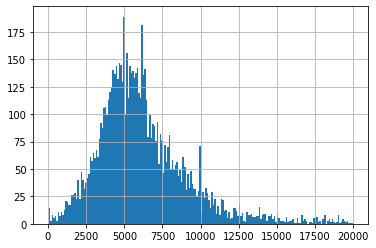

In [17]:
final,final_no_dummies=makeDataFrame(filename)

In [18]:
final.shape

(7823, 37)

In [19]:
filename_json='/content/drive/My Drive/domymazowieckie/dfMazowieckie.json'

In [20]:
final.to_json(filename_json)

In [21]:
from sklearn import preprocessing

In [22]:
df=final.copy()

In [23]:
df['lPokoi']=final.loc[:,'lPokoi']/10
df["powierzchnia_corr"]=np.log(final["powierzchnia_corr"])/10
df["powierzchniaDzialki_corr"]=np.log(final["powierzchniaDzialki_corr"]+1)/14
df["rokBudowy_corr"]=np.power(final["rokBudowy_corr"]-1899,4)/3e8
df["cena/m"]=final["cena/m"]/20000

(array([   8.,   36.,  638.,    0., 1651., 3743.,  697.,    0.,  405.,
         645.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

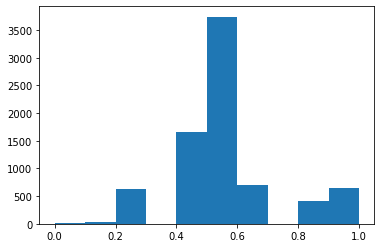

In [24]:
plt.hist(final.loc[:,'lPokoi']/10)

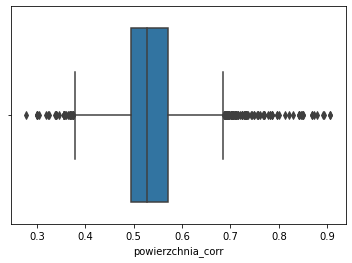

In [25]:
sns.boxplot(x=(np.log(final["powierzchnia_corr"])/10))

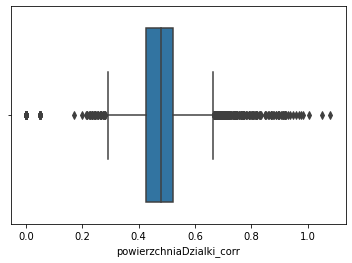

In [26]:
sns.boxplot(x=(np.log(final["powierzchniaDzialki_corr"]+1)/14))

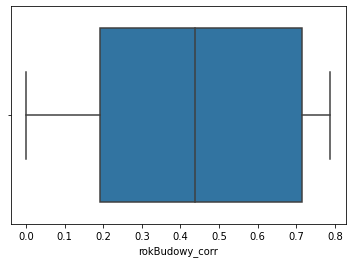

In [27]:
sns.boxplot(x=(np.power(final["rokBudowy_corr"]-1899,4)/3e8))

(array([ 453., 1386.,  406.,  441.,  874.,  844.,  670.,  358.,  429.,
        1962.]),
 array([3.33333333e-09, 7.88071283e-02, 1.57614253e-01, 2.36421378e-01,
        3.15228503e-01, 3.94035628e-01, 4.72842753e-01, 5.51649878e-01,
        6.30457003e-01, 7.09264128e-01, 7.88071253e-01]),
 <a list of 10 Patch objects>)

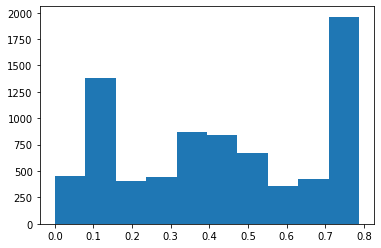

In [28]:
plt.hist(np.power(final["rokBudowy_corr"]-1899,4)/3e8)

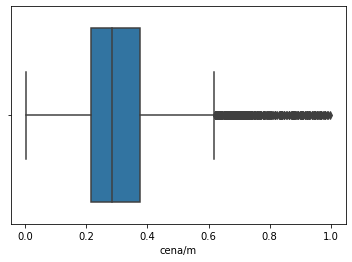

In [29]:
sns.boxplot(x=final["cena/m"]/20000)

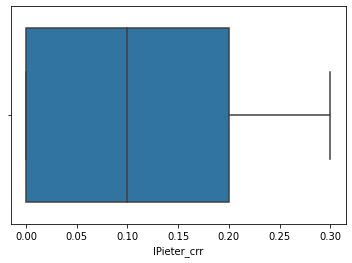

In [30]:
sns.boxplot(x=final["lPieter_crr"]/10)

(array([2569.,    0.,    0., 3286.,    0.,    0., 1630.,    0.,    0.,
         338.]),
 array([0.  , 0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.3 ]),
 <a list of 10 Patch objects>)

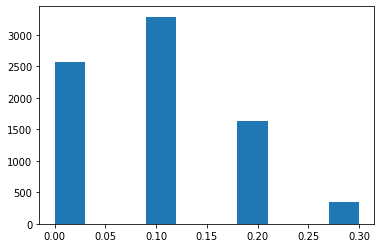

In [31]:
plt.hist(final["lPieter_crr"]/10)

(array([3.000e+00, 0.000e+00, 0.000e+00, 1.700e+01, 4.200e+01, 1.800e+02,
        1.976e+03, 3.808e+03, 3.410e+02, 9.900e+01]),
 array([-1.106265  , -0.95272183, -0.79917867, -0.6456355 , -0.49209233,
        -0.33854917, -0.185006  , -0.03146283,  0.12208033,  0.2756235 ,
         0.42916667]),
 <a list of 10 Patch objects>)

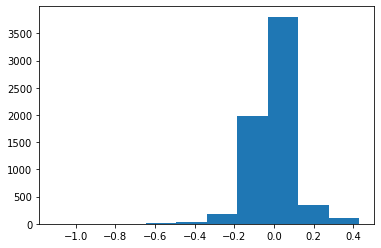

In [32]:
plt.hist((final["locationX"]-21)/4)

(array([1.000e+00, 3.100e+01, 5.400e+01, 2.160e+02, 4.400e+01, 3.114e+03,
        2.588e+03, 2.670e+02, 1.300e+02, 2.100e+01]),
 array([-1.00208333, -0.81940278, -0.63672222, -0.45404167, -0.27136111,
        -0.08868056,  0.094     ,  0.27668056,  0.45936111,  0.64204167,
         0.82472222]),
 <a list of 10 Patch objects>)

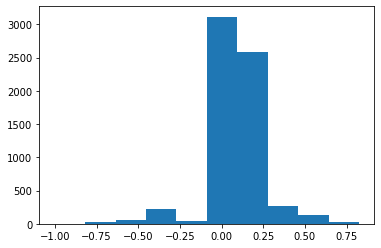

In [33]:
plt.hist((final["locationY"]-52)/2)

In [34]:
final.head()

,lPokoi,powierzchnia_corr,powierzchniaDzialki_corr,rokBudowy_corr,cena/m,lPieter_crr,locationX,locationY,rodzajZabudowy_0,rodzajZabudowy_bliźniak,rodzajZabudowy_dworek/pałac,rodzajZabudowy_gospodarstwo,rodzajZabudowy_kamienica,rodzajZabudowy_szeregowiec,rodzajZabudowy_wolnostojący,materialBudynku_0,materialBudynku_beton,materialBudynku_beton komórkowy,materialBudynku_cegła,materialBudynku_drewno,materialBudynku_inne,materialBudynku_keramzyt,materialBudynku_pustak,materialBudynku_silikat,stanWykonczenia_0,stanWykonczenia_do remontu,stanWykonczenia_do wykończenia,stanWykonczenia_do zamieszkania,stanWykonczenia_stan surowy otwarty,stanWykonczenia_stan surowy zamknięty,okna_0,okna_aluminiowe,okna_brak,okna_drewniane,okna_plastikowe,rynek_pierwotny,rynek_wtórny
0,6,320.00,1000,2019,6062.503125,1,21.223696,52.245856,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
1,5,154.00,750,2021,5186.363636,0,20.625000,52.108889,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0
2,3,80.00,2356,1950,5612.500000,1,20.683333,52.433333,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
3,4,152.91,220,2022,4250.866523,1,21.016667,52.066667,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0
4,4,106.00,960,2020,2924.528302,0,19.700000,52.550000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0


In [35]:
#min_max_scaler = preprocessing.MinMaxScaler()
#data_scaled = min_max_scaler.fit_transform(final.values)
#df = pd.DataFrame(data_scaled ,columns=final.columns.values)
#df  = df.fillna(0)

In [42]:
final.head()

,lPokoi,powierzchnia_corr,powierzchniaDzialki_corr,rokBudowy_corr,cena/m,lPieter_crr,locationX,locationY,rodzajZabudowy_0,rodzajZabudowy_bliźniak,rodzajZabudowy_dworek/pałac,rodzajZabudowy_gospodarstwo,rodzajZabudowy_kamienica,rodzajZabudowy_szeregowiec,rodzajZabudowy_wolnostojący,materialBudynku_0,materialBudynku_beton,materialBudynku_beton komórkowy,materialBudynku_cegła,materialBudynku_drewno,materialBudynku_inne,materialBudynku_keramzyt,materialBudynku_pustak,materialBudynku_silikat,stanWykonczenia_0,stanWykonczenia_do remontu,stanWykonczenia_do wykończenia,stanWykonczenia_do zamieszkania,stanWykonczenia_stan surowy otwarty,stanWykonczenia_stan surowy zamknięty,okna_0,okna_aluminiowe,okna_brak,okna_drewniane,okna_plastikowe,rynek_pierwotny,rynek_wtórny
0,6,320.00,1000,2019,6062.503125,1,21.223696,52.245856,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
1,5,154.00,750,2021,5186.363636,0,20.625000,52.108889,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0
2,3,80.00,2356,1950,5612.500000,1,20.683333,52.433333,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
3,4,152.91,220,2022,4250.866523,1,21.016667,52.066667,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0
4,4,106.00,960,2020,2924.528302,0,19.700000,52.550000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0


(array([   8.,   36.,  183.,  455., 1651., 2334., 1409.,  697.,  405.,
         645.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

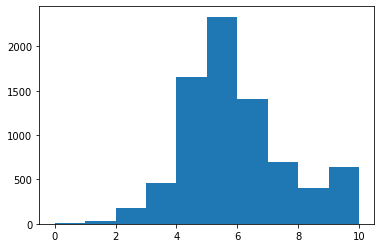

In [109]:
plt.hist(final['lPokoi'])

(array([2971., 3152., 1007.,  350.,  143.,   55.,   48.,   25.,   13.,
           8.]),
 array([  16. ,  163.2,  310.4,  457.6,  604.8,  752. ,  899.2, 1046.4,
        1193.6, 1340.8, 1488. ]),
 <a list of 10 Patch objects>)

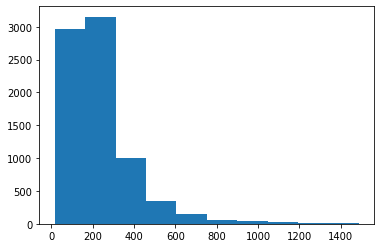

In [115]:
plt.hist(final[final['powierzchnia_corr']<1500]['powierzchnia_corr'])

(array([2490., 2079., 1314.,  576.,  356.,  167.,  190.,   82.,   49.,
          50.]),
 array([   0. ,  499.7,  999.4, 1499.1, 1998.8, 2498.5, 2998.2, 3497.9,
        3997.6, 4497.3, 4997. ]),
 <a list of 10 Patch objects>)

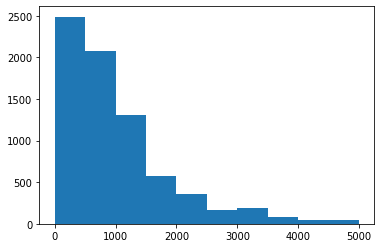

In [117]:
plt.hist(final[final['powierzchniaDzialki_corr']<5000]['powierzchniaDzialki_corr'])


(array([  21.,   25.,   84.,   61.,  180.,  197., 1412.,  821., 2033.,
        2989.]),
 array([1900. , 1912.3, 1924.6, 1936.9, 1949.2, 1961.5, 1973.8, 1986.1,
        1998.4, 2010.7, 2023. ]),
 <a list of 10 Patch objects>)

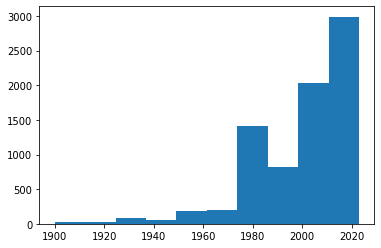

In [118]:
plt.hist(final['rokBudowy_corr'])

(array([ 308., 1318., 2732., 1829.,  895.,  351.,  173.,  104.,   57.,
          56.]),
 array([   38.75      ,  2032.01957143,  4025.28914286,  6018.55871429,
         8011.82828571, 10005.09785714, 11998.36742857, 13991.637     ,
        15984.90657143, 17978.17614286, 19971.44571429]),
 <a list of 10 Patch objects>)

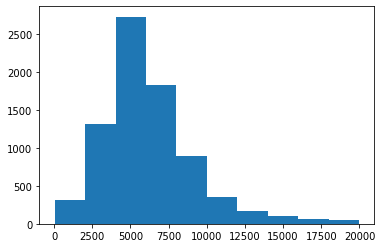

In [124]:
plt.hist(final['cena/m'])

In [119]:
final_plots=final.copy()

In [122]:
final_plots=final_plots[final_plots['powierzchnia_corr']<1500]
final_plots=final_plots[final_plots['powierzchniaDzialki_corr']<5000]

In [48]:
from sklearn.cluster import KMeans

In [170]:
final_plots.head()

,lPokoi,powierzchnia_corr,powierzchniaDzialki_corr,rokBudowy_corr,cena/m,lPieter_crr,locationX,locationY
0,6,320.00,1000,2019,6062.503125,1,21.223696,52.245856
1,5,154.00,750,2021,5186.363636,0,20.625000,52.108889
2,3,80.00,2356,1950,5612.500000,1,20.683333,52.433333
3,4,152.91,220,2022,4250.866523,1,21.016667,52.066667
4,4,106.00,960,2020,2924.528302,0,19.700000,52.550000


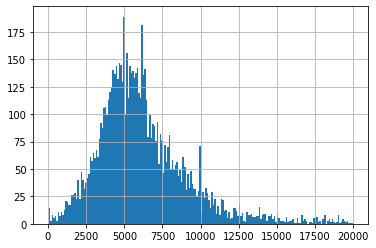

In [87]:
final,final_no_dummies=makeDataFrame(filename)

In [1]:
#final_plots=final[['powierzchnia_corr','powierzchniaDzialki_corr','rokBudowy_corr','cena/m','locationX','locationY']].copy()
final_plots=final[['powierzchnia_corr','cena/m']].copy()
final_plots=final_plots[final_plots['powierzchnia_corr']<1500]
final_plots=final_plots[final_plots['powierzchniaDzialki_corr']<5000]
final_no_dummies=final_no_dummies[final_no_dummies['powierzchnia_corr']<1500]
final_no_dummies=final_no_dummies[final_no_dummies['powierzchniaDzialki_corr']<5000]

NameError: ignored

In [190]:
final_plots.locationX=final_plots.locationX.fillna(10)
final_plots.locationY=final_plots.locationY.fillna(40)

In [105]:
from sklearn.mixture import GaussianMixture

In [106]:
af = GaussianMixture().fit(final.values)

In [108]:
set(af.predict(final.values))

{0}

In [196]:
values=[]
for i in [10,20,50,100,150,200]:
  kmeans = KMeans(n_clusters=i, random_state=0).fit(final_plots.values)
  values.append(kmeans.score(final_plots.values))

In [197]:
np.abs(values)

array([5.41367971e+09, 2.75149919e+09, 1.16265188e+09, 6.46937701e+08,
       4.54040768e+08, 3.52851835e+08])

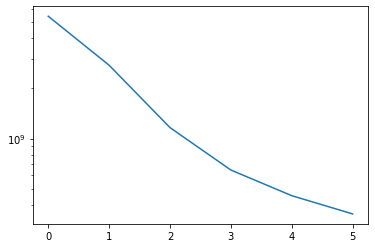

In [198]:
plt.plot(np.abs(values))
plt.yscale('log')


In [174]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(final_plots.values)


In [175]:
final_no_dummies['kmean']=kmeans.predict(final_plots.values)

In [176]:
final_no_dummies.head()

,lPokoi,rodzajZabudowy,materialBudynku,stanWykonczenia,okna,rynek,powierzchnia_corr,powierzchniaDzialki_corr,rokBudowy_corr,cena/m,lPieter_crr,locationX,locationY,kmean
0,6,wolnostojący,cegła,do wykończenia,0,wtórny,320.00,1000,2019,6062.503125,1,21.223696,52.245856,2
1,5,0,beton komórkowy,do wykończenia,plastikowe,pierwotny,154.00,750,2021,5186.363636,0,20.625000,52.108889,8
2,3,wolnostojący,0,do remontu,0,wtórny,80.00,2356,1950,5612.500000,1,20.683333,52.433333,3
3,4,bliźniak,silikat,do wykończenia,plastikowe,pierwotny,152.91,220,2022,4250.866523,1,21.016667,52.066667,1
4,4,wolnostojący,pustak,stan surowy otwarty,brak,pierwotny,106.00,960,2020,2924.528302,0,19.700000,52.550000,5


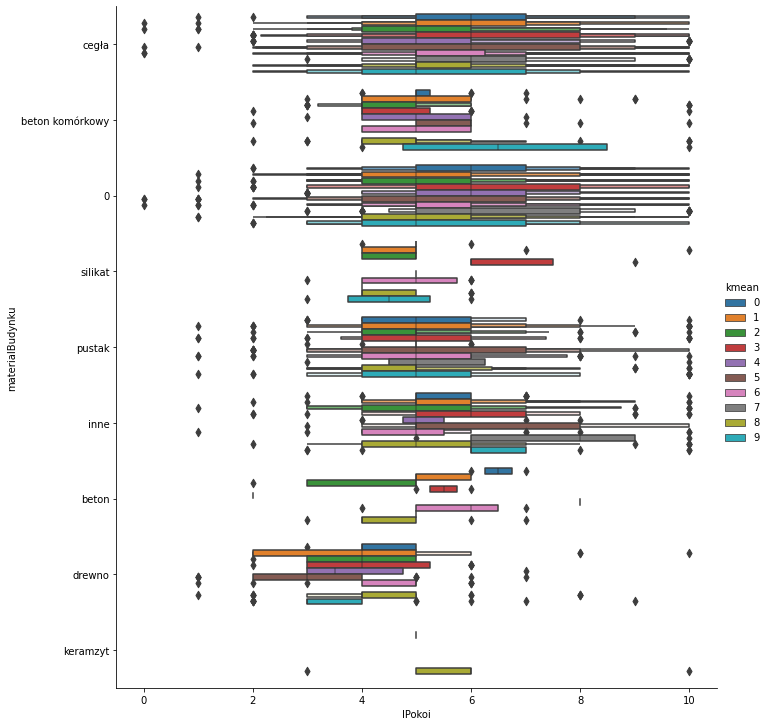

In [177]:
sns.catplot(y="materialBudynku", x="lPokoi", hue="kmean", kind="boxen", data=final_no_dummies,height=10)

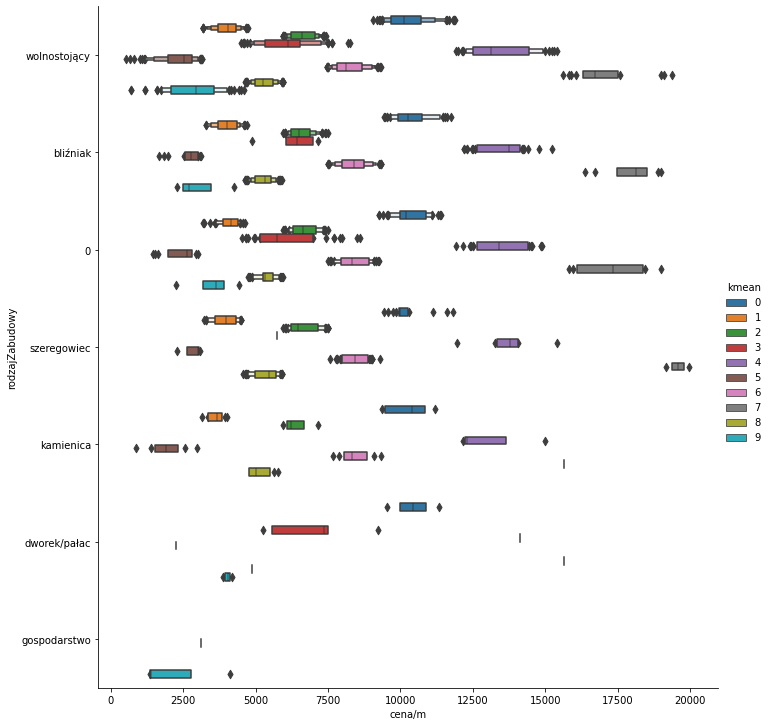

In [178]:
sns.catplot(y="rodzajZabudowy", x="cena/m", hue="kmean", kind="boxen", data=final_no_dummies[final_no_dummies['materialBudynku']=='cegła'],height=10)

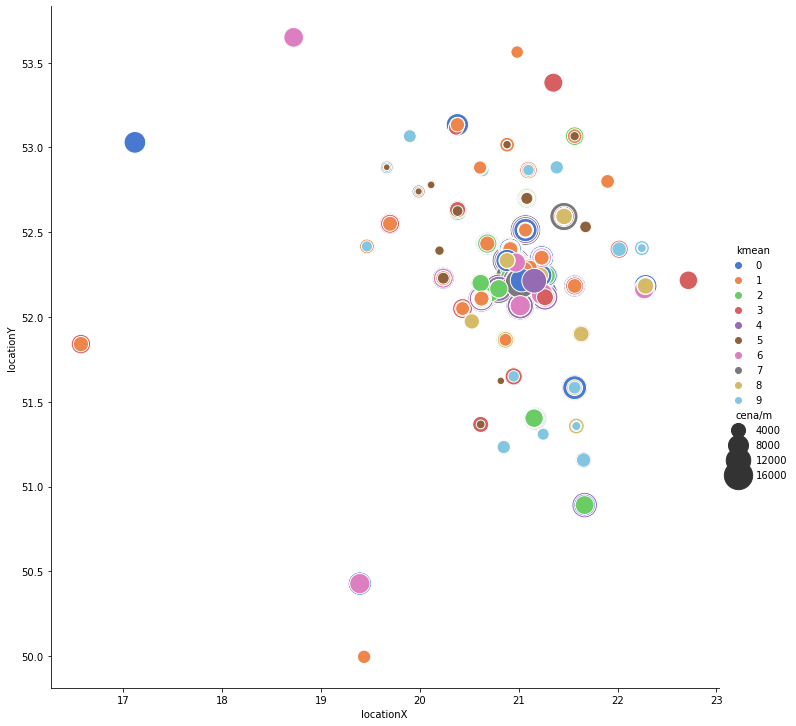

In [179]:
sns.relplot(y="locationY", x="locationX", hue="kmean", data=final_no_dummies,size='cena/m',height=10, sizes=(1, 1000),palette="muted")

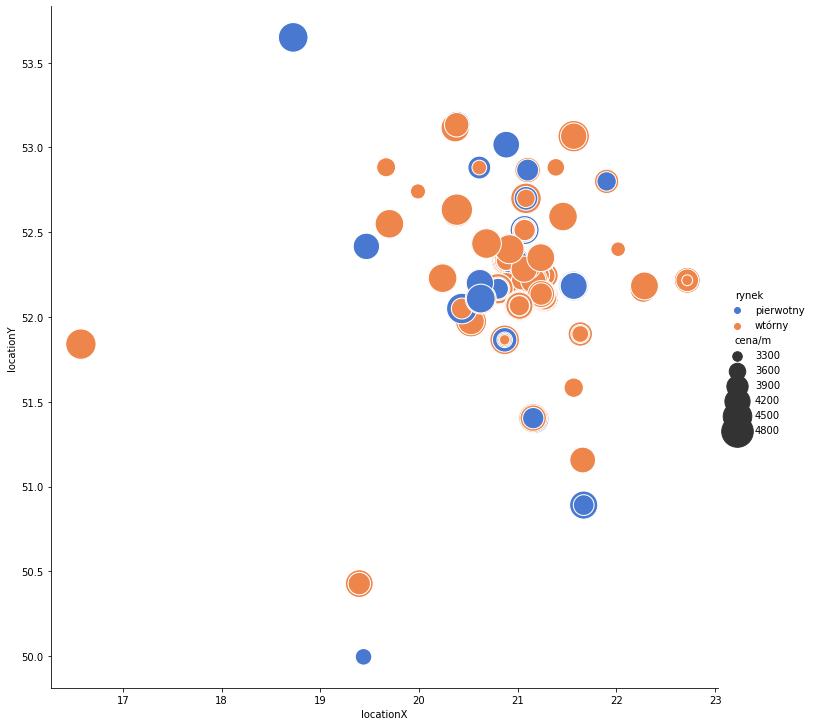

In [182]:
sns.relplot(y="locationY", x="locationX", hue="rynek", data=final_no_dummies[final_no_dummies['kmean']==1],size='cena/m',height=10, sizes=(1, 1000),palette="muted")